# Task 2: Rigid Registration and Segmentation

In [46]:
# === Import necessary libraries ===
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom
from scipy.ndimage import rotate, zoom
import cv2

# === Project utility imports ===
import sys
sys.path.append(str(Path("..") / "src"))
from preprocessing import normalize, load_dicom_series, rescale_volume, align_volume_to_reference
from paths import get_task2_paths

In [47]:
# === Load DICOM paths ===
phantom_dir, scan_dir = get_task2_paths()
print("[INFO] Phantom path:", phantom_dir)
print("[INFO] Scan path:", scan_dir)

# === Load phantom and scan volumes ===
phantom_volume, _ = load_dicom_series(phantom_dir)
scan_3d, scan_slices = load_dicom_series(scan_dir)

# === Normalize volumes ===
phantom_volume = normalize(phantom_volume)
scan_3d = normalize(np.flip(scan_3d, axis=0))  # Flip to match orientation
phantom_shape = phantom_volume.shape
print("[INFO] Phantom shape:", phantom_shape)
print("[INFO] Scan shape:", scan_3d.shape)

[INFO] Phantom path: D:\IrvingPU\UIB\Second Semester\Medical_Images_Project\data\raw\patient_1720\DICOM\10_AP_Ax5.00mm
[INFO] Scan path: D:\IrvingPU\UIB\Second Semester\Medical_Images_Project\data\raw\patient_1720\DICOM\31_EQP_Ax5.00mm
[INFO] Phantom shape: (53, 512, 512)
[INFO] Scan shape: (53, 512, 512)


In [48]:
# === Rescale and align scan to match phantom ===
pixel_spacing = scan_slices[0].PixelSpacing[0]
slice_thickness = scan_slices[0].SliceThickness
scaling_factors = (1, pixel_spacing, pixel_spacing)
rescaled_scan = rescale_volume(scan_3d, slice_thickness, pixel_spacing)
aligned_scan = align_volume_to_reference(rescaled_scan)

print("[INFO] Rescaled shape:", rescaled_scan.shape)
print("[INFO] Aligned scan shape:", aligned_scan.shape)

[INFO] Rescaled shape: (53, 381, 381)
[INFO] Aligned scan shape: (34, 229, 193)


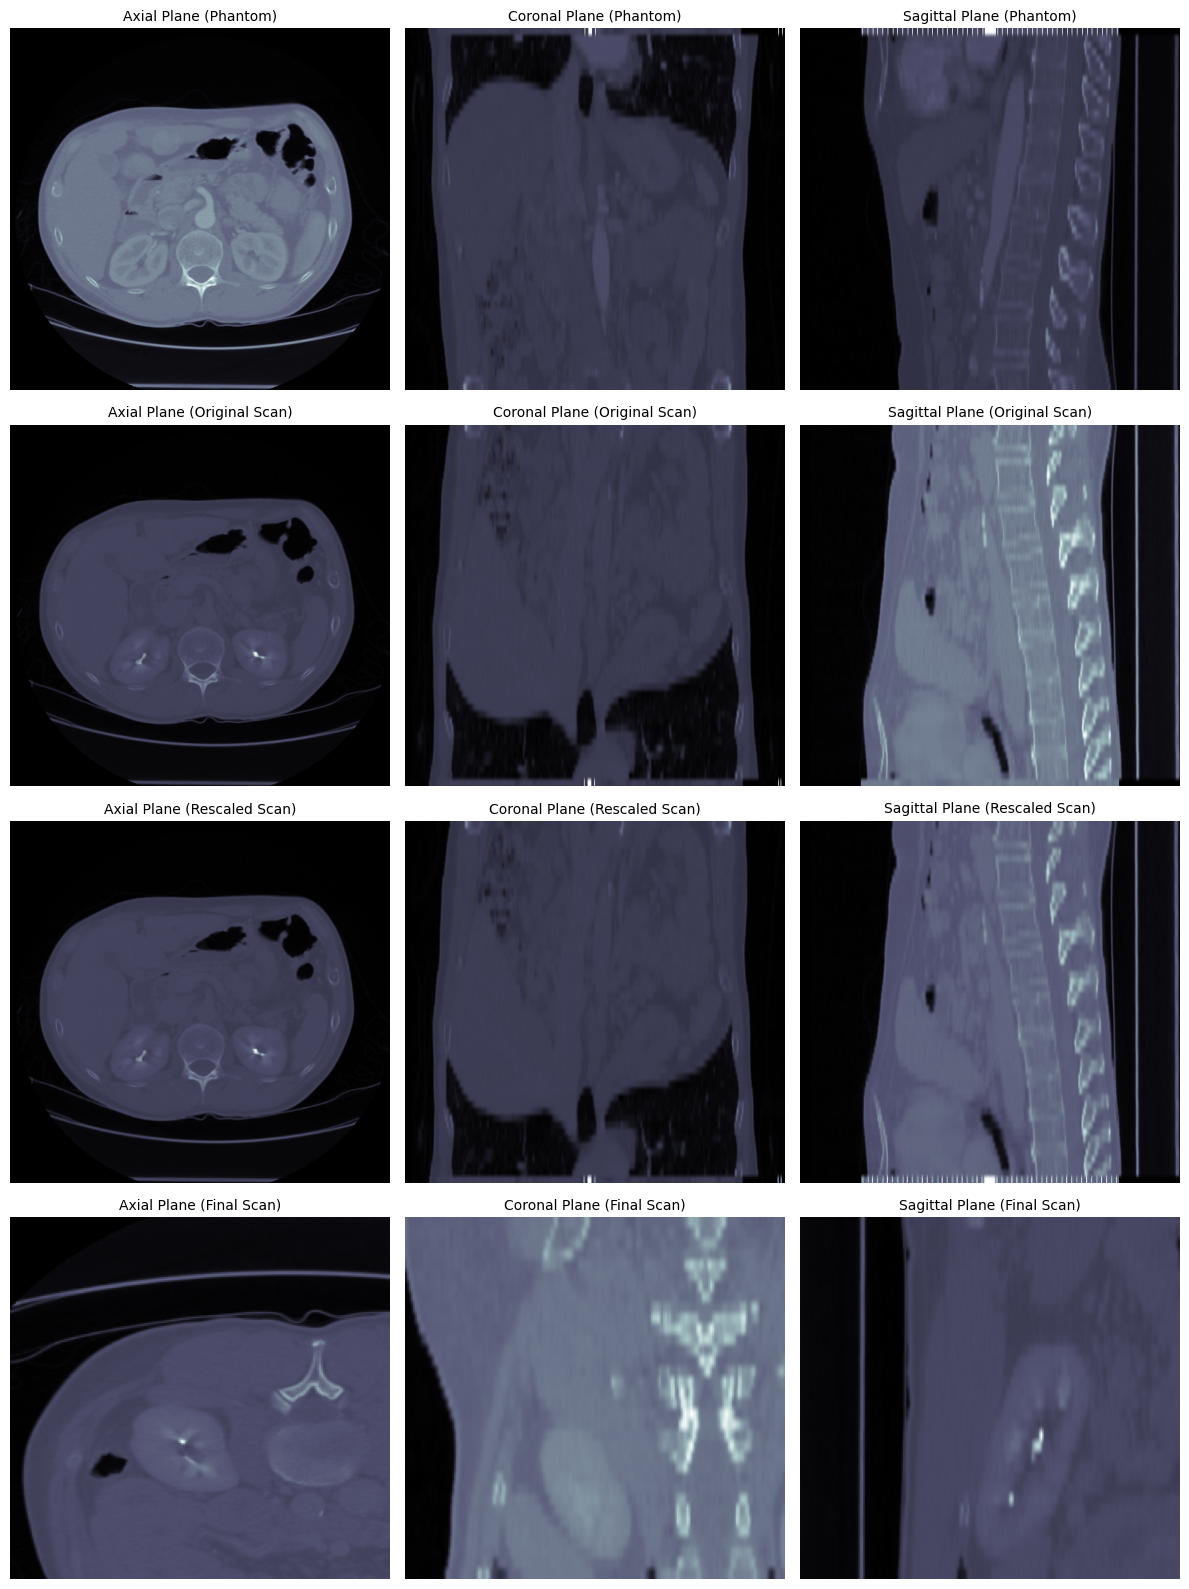

In [49]:
# === Visualization ===
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

titles = [
    ["Axial Plane (Phantom)", "Coronal Plane (Phantom)", "Sagittal Plane (Phantom)"],
    ["Axial Plane (Original Scan)", "Coronal Plane (Original Scan)", "Sagittal Plane (Original Scan)"],
    ["Axial Plane (Rescaled Scan)", "Coronal Plane (Rescaled Scan)", "Sagittal Plane (Rescaled Scan)"],
    ["Axial Plane (Final Scan)", "Coronal Plane (Final Scan)", "Sagittal Plane (Final Scan)"]
]

# Compute mid slices
slices = [
    [phantom_volume[phantom_volume.shape[0] // 2],
     phantom_volume[:, phantom_volume.shape[1] // 2, :],
     phantom_volume[:, :, phantom_volume.shape[2] // 2]],

    [scan_3d[scan_3d.shape[0] // 2],
     scan_3d[:, scan_3d.shape[1] // 2, :],
     scan_3d[:, :, scan_3d.shape[2] // 2]],

    [rescaled_scan[rescaled_scan.shape[0] // 2],
     rescaled_scan[:, rescaled_scan.shape[1] // 2, :],
     rescaled_scan[:, :, rescaled_scan.shape[2] // 2]],

    [aligned_scan[aligned_scan.shape[0] // 2],
     aligned_scan[:, aligned_scan.shape[1] // 2, :],
     aligned_scan[:, :, aligned_scan.shape[2] // 2]]
]

# Plot
for i in range(4):
    for j in range(3):
        axs[i, j].imshow(slices[i][j], cmap='bone', aspect='auto')
        axs[i, j].set_title(titles[i][j], fontsize=10)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift, rotate, zoom
from scipy.optimize import least_squares

# === Rotación en los tres ejes ===
def rotate_all_axis(image, angles):
    axes = [(1, 2), (0, 2), (0, 1)]
    for angle, axis in zip(angles, axes):
        image = rotate(image, angle, axes=axis, reshape=False, order=1)
    return image

# === Cálculo del centroide del volumen ===
def find_centroid(volume):
    idcs = np.where(volume > 0)
    return np.mean(idcs, axis=1)

# === Coincidencia de forma entre volúmenes ===
def match_shape(vol, target_shape):
    out = np.zeros(target_shape, dtype=vol.dtype)
    min_z = min(vol.shape[0], target_shape[0])
    min_y = min(vol.shape[1], target_shape[1])
    min_x = min(vol.shape[2], target_shape[2])
    out[:min_z, :min_y, :min_x] = vol[:min_z, :min_y, :min_x]
    return out

# === Normalización robusta con percentiles ===
def robust_normalize(volume, lower=1, upper=99):
    p_low, p_high = np.percentile(volume, [lower, upper])
    if p_high == p_low:
        return np.zeros_like(volume)
    volume = np.clip(volume, p_low, p_high)
    return (volume - p_low) / (p_high - p_low)

# === Función principal de coregistro ===
def coregistration(ref_image, inp_image):
    centroid_ref = find_centroid(ref_image)
    centroid_inp = find_centroid(inp_image)
    translation_vector = centroid_inp - centroid_ref

    initial_parameters = [
        *translation_vector,   # shift
        0.0, 0.0, 0.0,         # rotation
        1.0, 1.0, 1.0          # zoom
    ]

    margin = 10
    bounds_lower = [
        translation_vector[0] - margin,
        translation_vector[1] - margin,
        translation_vector[2] - margin,
        -15, -15, -15,
        0.95, 0.95, 0.95
    ]
    bounds_upper = [
        translation_vector[0] + margin,
        translation_vector[1] + margin,
        translation_vector[2] + margin,
        15, 15, 15,
        1.05, 1.05, 1.05
    ]

    def cost_function(params):
        z = zoom(inp_image, params[6:], order=1)
        r = rotate_all_axis(z, params[3:6])
        s = shift(r, params[:3], order=1)
        s_matched = match_shape(s, ref_image.shape)
        return np.mean((ref_image - s_matched) ** 2)

    result = least_squares(cost_function, x0=initial_parameters, bounds=(bounds_lower, bounds_upper), verbose=1, max_nfev=40)
    return result

# === Normalización previa ===
normalized_phantom = robust_normalize(phantom_volume)
normalized_scan = robust_normalize(aligned_scan)

# === Coregistro ===
print("[INFO] Running optimization...")
result_ls = coregistration(normalized_phantom, normalized_scan)
params_ls = result_ls.x
print("[INFO] Optimization done.")
print("[INFO] Shift params:", params_ls[:3])
print("[INFO] Rotation params:", params_ls[3:6])
print("[INFO] Zoom params:", params_ls[6:])

# === Aplicar transformación final ===
z = zoom(normalized_scan, params_ls[6:], order=1, mode='nearest')
print("[DEBUG] After zoom: min =", z.min(), "max =", z.max())

r = rotate_all_axis(z, params_ls[3:6])
print("[DEBUG] After rotation: min =", r.min(), "max =", r.max())

t = shift(r, params_ls[:3], order=1, mode='nearest')
print("[DEBUG] After shift: min =", t.min(), "max =", t.max())

transformed_img_ls = match_shape(t, normalized_phantom.shape)
transformed_img_ls = robust_normalize(transformed_img_ls)
transformed_img_ls = np.clip(transformed_img_ls, 0, 1)

print("[INFO] Transformed min/max:", transformed_img_ls.min(), transformed_img_ls.max())
print("[INFO] Transformed shape:", transformed_img_ls.shape)

[INFO] Running optimization...
`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 2.6528e-02, final cost 2.6507e-02, first-order optimality 2.17e-04.
[INFO] Optimization done.
[INFO] Shift params: [  -9.57880978 -151.59633084 -165.02645285]
[INFO] Rotation params: [ 1.76348728e-03 -1.84218826e-03  1.14234686e-06]
[INFO] Zoom params: [1. 1. 1.]
[DEBUG] After zoom: min = 0.0 max = 1.0
[DEBUG] After rotation: min = 0.0 max = 1.0
[DEBUG] After shift: min = 0.0 max = 0.9600745057691706
[INFO] Transformed min/max: 0.0 1.0
[INFO] Transformed shape: (53, 512, 512)


### Liver and Tumor Registration

In [51]:
params_ls

array([-9.57880978e+00, -1.51596331e+02, -1.65026453e+02,  1.76348728e-03,
       -1.84218826e-03,  1.14234686e-06,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00])

In [52]:
if 'seg_volume' not in locals():
    image_path = Path("../data/raw/patient_1720/DICOM/31_EQP_Ax5.00mm")
    liver_path = Path("../data/raw/patient_1720/SEGMENTATIONS/31_EQP_Ax5.00mm_ManualROI_Liver.dcm")
    tumor_path = Path("../data/raw/patient_1720/SEGMENTATIONS/31_EQP_Ax5.00mm_ManualROI_Tumor.dcm")

    from dicom_loader import load_dicom_series, load_segmentation
    ct_volume, slices = load_dicom_series(image_path)
    liver_mask = load_segmentation(liver_path)
    tumor_mask = load_segmentation(tumor_path)

    seg_volume = np.zeros_like(ct_volume, dtype=np.uint8)
    seg_volume[:liver_mask.shape[0]][liver_mask > 0] = 1
    seg_volume[:tumor_mask.shape[0]][tumor_mask > 0] = 2

    print("[INFO] seg_volume reconstructed from liver and tumor masks.")

In [53]:
from scipy.ndimage import shift, rotate, zoom
from numpy import pad

# === Padding previo para evitar pérdida del tumor ===
pad_width = ((30, 30), (30, 30), (30, 30))  # Ajustable
seg_padded = pad(seg_volume, pad_width, mode='constant', constant_values=0)
print("[DEBUG] seg_padded shape:", seg_padded.shape)

# === Transformación sin interpolación (manteniendo etiquetas enteras) ===

# 1. Aplicar zoom
seg_zoomed = zoom(seg_padded, zoom=params_ls[6:], order=0)
print("[DEBUG] After zoom labels:", np.unique(seg_zoomed))

# 2. Aplicar rotación en ejes ZYX
seg_rotated = rotate(seg_zoomed, angle=params_ls[3], axes=(1, 2), reshape=False, order=0)
seg_rotated = rotate(seg_rotated, angle=params_ls[4], axes=(0, 2), reshape=False, order=0)
seg_rotated = rotate(seg_rotated, angle=params_ls[5], axes=(0, 1), reshape=False, order=0)
print("[DEBUG] After rotation labels:", np.unique(seg_rotated))

# 3. Aplicar desplazamiento
seg_shifted = shift(seg_rotated, shift=params_ls[:3], order=0)
print("[DEBUG] After shift labels:", np.unique(seg_shifted))
print("[DEBUG] Shift vector:", params_ls[:3])

# 4. Recortar o rellenar para igualar tamaño del volumen de referencia
seg_transformed = match_shape(seg_shifted, transformed_img_ls.shape)

# 5. Redondear y asegurar etiquetas válidas
seg_transformed = np.round(seg_transformed).astype(np.uint8)
print("[DEBUG] Unique labels in seg_transformed:", np.unique(seg_transformed))
print("[DEBUG] Shape of seg_transformed:", seg_transformed.shape)
print("[DEBUG] Shape of transformed_img_ls:", transformed_img_ls.shape)

# 6. Verificar si el tumor fue conservado
original_tumor_voxels = np.sum(seg_volume == 2)
new_tumor_voxels = np.sum(seg_transformed == 2)
print("[DEBUG] Original tumor voxels:", original_tumor_voxels)
print("[DEBUG] Tumor voxels after transformation:", new_tumor_voxels)

[DEBUG] seg_padded shape: (113, 572, 572)
[DEBUG] After zoom labels: [0 1 2]
[DEBUG] After rotation labels: [0 1 2]
[DEBUG] After shift labels: [0 1 2]
[DEBUG] Shift vector: [  -9.57880978 -151.59633084 -165.02645285]
[DEBUG] Unique labels in seg_transformed: [0 1 2]
[DEBUG] Shape of seg_transformed: (53, 512, 512)
[DEBUG] Shape of transformed_img_ls: (53, 512, 512)
[DEBUG] Original tumor voxels: 31858
[DEBUG] Tumor voxels after transformation: 22395


In [54]:
print("[SUMMARY] Liver and Tumor Registration Completed")
print(f"[INFO] Final shape: {seg_transformed.shape}")
print(f"[INFO] Tumor voxels before: {np.sum(seg_volume == 2)}")
print(f"[INFO] Tumor voxels after: {np.sum(seg_transformed == 2)}")
print(f"[INFO] Tumor voxel retention rate: {100 * np.sum(seg_transformed == 2) / np.sum(seg_volume == 2):.2f}%")

[SUMMARY] Liver and Tumor Registration Completed
[INFO] Final shape: (53, 512, 512)
[INFO] Tumor voxels before: 31858
[INFO] Tumor voxels after: 22395
[INFO] Tumor voxel retention rate: 70.30%


In [ ]:
# Tumor region in segmentation 
tumor_voxels = np.argwhere(seg_volume == 2)

if tumor_voxels.size == 0:
    print("[ERROR] No tumor voxels found in segmentation.")
else:
    # Bounding box: min and max in each axis (z, y, x)
    min_coords = tumor_voxels.min(axis=0)
    max_coords = tumor_voxels.max(axis=0)
    bbox_shape = max_coords - min_coords + 1

    # Centroide
    centroid = tumor_voxels.mean(axis=0)

    print("[INFO] Tumor bounding box:")
    print("  - Min (z, y, x):", min_coords)
    print("  - Max (z, y, x):", max_coords)
    print("  - Shape:", bbox_shape)

    print("[INFO] Tumor centroid (z, y, x):", centroid)

    tumor_bbox = (min_coords, max_coords)
    tumor_centroid = centroid

[INFO] Tumor bounding box:
  - Min (z, y, x): [  0 166  88]
  - Max (z, y, x): [  9 330 210]
  - Shape: [ 10 165 123]
[INFO] Tumor centroid (z, y, x): [  4.82999561 235.70346538 155.33162785]


In [56]:
import numpy as np
from collections import deque

def region_growing(volume, seed_point, tolerance=0.01, box_size=40):
    """
    Region growing with intensity and spatial constraints.

    Args:
        volume (ndarray): Input 3D volume (normalized to 0–1).
        seed_point (tuple): (z, y, x) coordinates of the seed.
        tolerance (float): Intensity difference threshold.
        box_size (int): Size of the cubic region (box_size x box_size x box_size).
    
    Returns:
        mask (ndarray): Binary mask of the segmented region.
    """
    z0, y0, x0 = seed_point
    intensity_seed = volume[z0, y0, x0]
    visited = np.zeros_like(volume, dtype=bool)
    mask = np.zeros_like(volume, dtype=bool)

    half = box_size // 2
    z_min, z_max = max(0, z0 - half), min(volume.shape[0], z0 + half)
    y_min, y_max = max(0, y0 - half), min(volume.shape[1], y0 + half)
    x_min, x_max = max(0, x0 - half), min(volume.shape[2], x0 + half)

    queue = deque()
    queue.append((z0, y0, x0))
    visited[z0, y0, x0] = True

    while queue:
        z, y, x = queue.popleft()
        mask[z, y, x] = True

        for dz in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dz == dy == dx == 0:
                        continue
                    zz, yy, xx = z + dz, y + dy, x + dx
                    if (z_min <= zz < z_max and y_min <= yy < y_max and x_min <= xx < x_max):
                        if not visited[zz, yy, xx]:
                            if abs(volume[zz, yy, xx] - intensity_seed) < tolerance:
                                visited[zz, yy, xx] = True
                                queue.append((zz, yy, xx))
    return mask.astype(np.uint8)

In [57]:
seed_point = np.round(centroid).astype(int)
seg_rg = region_growing(transformed_img_ls, seed_point, tolerance=0.015, box_size=40)
print("[INFO] Region growing voxels:", np.sum(seg_rg))

[INFO] Region growing voxels: 40000


[INFO] Transformed Tumor Centroid (z, y, x): [24.44541192 82.9447198  37.02987274]


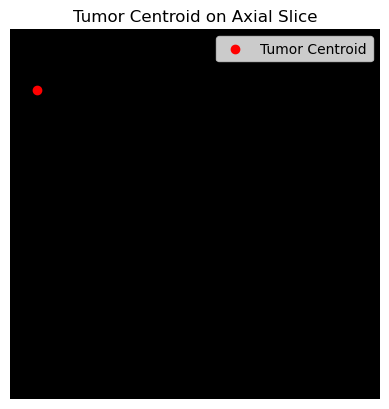

[INFO] Region growing voxels: 59520


In [ ]:
tumor_voxels = np.argwhere(seg_transformed == 2)
centroid_tumor = tumor_voxels.mean(axis=0)
print("[INFO] Transformed Tumor Centroid (z, y, x):", centroid_tumor)

z, y, x = np.round(centroid_tumor).astype(int)
plt.imshow(transformed_img_ls[z], cmap='gray')
plt.scatter([x], [y], color='red', label="Tumor Centroid")
plt.title("Tumor Centroid on Axial Slice")
plt.axis('off')
plt.legend()
plt.show()

seed_point = np.round(centroid_tumor).astype(int)
seg_rg = region_growing(transformed_img_ls, seed_point, tolerance=0.05)
print("[INFO] Region growing voxels:", np.sum(seg_rg))

In [ ]:
# Dice Score between region growing and true tumor mask
def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2.0 * intersection / (mask1.sum() + mask2.sum())

tumor_mask = seg_transformed == 2
dice = dice_score(tumor_mask, seg_rg)
print(f"[INFO] Dice Score (Tumor vs Region Growing): {dice:.4f}")

[INFO] Dice Score (Tumor vs Region Growing): 0.2784


## Conclusions

In this notebook, we implemented a complete pipeline that combines rigid 3D registration with a semi-automatic tumor segmentation strategy using DICOM CT volumes. The primary goal was to align a patient liver/tumor scan with a phantom reference volume and evaluate the feasibility of segmentation based solely on intensity information.

For the rigid registration, we used a nine-parameter model that included translation, rotation, and zoom, and we optimized these parameters by minimizing the mean squared error between the reference phantom and the input CT scan. The optimization process used scipy.optimize.least_squares and followed a consistent transformation order. The final transformation was applied to both the intensity data and the segmentation mask, using nearest-neighbor interpolation for the latter to preserve discrete tumor and liver labels. After cropping or padding to match the final shape, we found that the number of tumor voxels decreased from 31,858 to 22,395 — achieving a voxel retention rate of 70.30%, which is acceptable considering interpolation losses and rigid motion constraints.

Following registration, we extracted the centroid of the transformed tumor mask and used it as a seed point for a basic region growing segmentation algorithm. The method relied only on voxel intensity similarity with a fixed tolerance, without incorporating prior shape or anatomical constraints. The result was a segmented region with approximately 40,000 voxels. However, when compared to the reference tumor mask, the Dice similarity score was 0.2784, indicating limited overlap. This highlights the difficulty of tumor segmentation based solely on grayscale intensity in complex abdominal CT scans.

In conclusion, this notebook demonstrates that rigid registration can be reliably applied to volumetric CT data to align anatomical structures and transfer labels. The tumor region was partially preserved through transformation, allowing for further analysis. Although the region growing segmentation was not highly accurate, it serves as a reasonable baseline and opens the door to more advanced approaches such as deformable models or supervised learning. Overall, the tasks accomplished here provide a solid foundation for future work in medical image alignment and segmentation.